In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

In [14]:
dval = dmyplant2.Validation.load_def_csv("input2.csv")
dval;

In [15]:
i = 2
vale = dval.iloc[i][['serialNumber','Validation Engine','val start']]

In [16]:
#e=dmyplant2.Engine.from_sn(mp,vale['serialNumber'], valstart=vale['val start'])
e=dmyplant2.Engine.from_sn(mp,1486144) # Forsa Hartmoor M1
#e=dmyplant2.Engine.from_sn(mp,1486144) # Forsa Hartmoor M1
#e=dmyplant2.Engine.from_sn(mp,1486152) # Forsa Hartmoor M2
#e=dmyplant2.Engine.from_sn(mp,1486176) # Forsa Hartmoor M3
#e=dmyplant2.Engine.from_sn(mp,1486174) # Forsa Hartmoor M4
#e=dmyplant2.Engine.from_sn(mp,1486197) # Forsa Hartmoor M5
#e=dmyplant2.Engine.from_sn(mp,1486198) # Forsa Hartmoor M6
#e=dmyplant2.Engine.from_sn(mp,1486236) # Forsa Hartmoor M7
#e=dmyplant2.Engine.from_sn(mp,1486225) # Forsa Hartmoor M8
#e=dmyplant2.Engine.from_sn(mp,1486251) # Forsa Hartmoor M9
#e=dmyplant2.Engine.from_sn(mp,1486255) # Forsa Hartmoor M10
#e=dmyplant2.Engine.from_sn(mp,1486272) # Forsa Hartmoor M11


In [17]:
# Ammerlaan Flowers 2, J420 Frage von David Sepulveda Lopez
#e=dmyplant2.Engine.from_sn(mp,5640011)

In [18]:
# for d in e.asset:
#     print(d, type(e[d]))
#     print(pf(e[d]), '\n')

In [19]:
pd.DataFrame.from_dict(e.dash, orient='index').T

,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,Forsa Hartmoor,M01,AL87,624,H12,24,4582.1,24.5,1486144,159396,183.0,2022-01-10,0,183,0.141


In [20]:
from dfsm import msgFSM
#fsm = msgFSM(e, skip_day=7)
fsm = msgFSM(e, p_from='2022-01-11')
fsm.run() # run Finite State Machine

Message - '9047 target load reached' found.


Scan Messages: 100%|███████████████████████████████████████████████████████| 6294/6294 [00:02<00:00, 2100.88 messages/s]


In [21]:
rdf = pd.DataFrame(fsm._starts)

In [22]:
print("""
****************
** Überblick: **
****************
""")
print(f"{'Motor':9}: {e} {e['Count_OpHour']} Bh")
print(f"{'Meldung':9}- '{'9047 target load reached'}' {'gefunden.' if any(fsm._messages['name'] == '9047') else 'wird berechnet.'}")
print(f"{'Zeitraum':9}: {fsm.first_message:%d.%m.%Y} bis {fsm.last_message:%d.%m.%Y}")
print(f"{'Dauer':9}: {fsm.period.days} Tage ~ {fsm.period.days / 365:2.1f} Jahre")
print()
print(f"{'GESAMT':9}: {rdf.shape[0]:5} Starts, {rdf[rdf.success].shape[0]:5} erfolgreich => {(rdf[rdf.success].shape[0] / rdf.shape[0]) * 100.0:3.1f} % der Starts erfolgreich.")
for mode in ['OFF', 'MANUAL', 'AUTO']:
    print(f"{mode:9}: {rdf[(rdf['mode'] == mode)].shape[0]:5} Starts, {rdf[((rdf.success) & (rdf['mode'] == mode))].shape[0]:5} erfolgreich => {(rdf[((rdf.success) & (rdf['mode'] == mode))].shape[0] / rdf[(rdf['mode'] == mode)].shape[0]) * 100.0:3.1f} % der Starts erfolgreich.")


****************
** Überblick: **
****************

Motor    : 1486144 M01 Forsa Hartmoor          183.0 Bh
Meldung  - '9047 target load reached' gefunden.
Zeitraum : 11.01.2022 bis 21.02.2022
Dauer    : 41 Tage ~ 0.1 Jahre

GESAMT   :   106 Starts,    54 erfolgreich => 50.9 % der Starts erfolgreich.
OFF      :     8 Starts,     0 erfolgreich => 0.0 % der Starts erfolgreich.
MANUAL   :    30 Starts,     2 erfolgreich => 6.7 % der Starts erfolgreich.
AUTO     :    66 Starts,    50 erfolgreich => 75.8 % der Starts erfolgreich.


In [23]:
rda = rdf
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True))]
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True) & (rdf['synchronize'] < 300.0) & (rdf['start-preparation'] < 300.0))]
#rda = rdf[((rdf['success'] == True) & (rdf['start-preparation'] < 1000.0))]
rda = rdf[((rdf['success'] == True))]
rda = rda[['success','mode','cumstarttime','start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']]
rda.round(2);

In [24]:
rda.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
cumstarttime,54.0,281.4,30.9,247.71,275.62,276.24,277.08,486.21
start-preparation,54.0,95.89,29.68,60.56,88.36,98.43,101.1,285.65
starter,54.0,3.94,0.22,3.53,3.83,3.94,4.14,4.34
hochlauf,54.0,20.91,2.31,17.15,18.86,20.58,22.78,27.04
idle,54.0,5.62,4.82,4.03,4.54,4.64,5.53,40.07
synchronize,54.0,22.12,21.96,1.0,4.88,9.03,40.35,95.9
load-ramp,54.0,132.92,22.46,66.25,125.46,128.23,142.35,187.69
target-operation,54,0 days 01:59:32.370370370,0 days 02:02:06.850494047,0 days 00:03:24,0 days 00:30:46.500000,0 days 01:03:21.500000,0 days 03:03:30.750000,0 days 09:05:11


In [25]:
longer_than_300s = rda[rdf['cumstarttime'] > 300.0]
longer_than_300s.round(2);

In [26]:
longer_than_300s.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
cumstarttime,5.0,339.67,81.94,300.45,302.12,303.97,305.58,486.21
start-preparation,5.0,138.71,82.15,100.08,101.7,102.92,103.19,285.65
starter,5.0,4.06,0.22,3.83,3.94,3.94,4.24,4.34
hochlauf,5.0,23.85,1.83,22.69,22.7,23.2,23.61,27.04
idle,5.0,12.98,15.15,6.15,6.15,6.16,6.36,40.07
synchronize,5.0,34.84,17.38,3.94,39.77,41.9,44.27,44.33
load-ramp,5.0,125.24,0.3,124.88,124.98,125.3,125.45,125.57
target-operation,5,0 days 03:42:22.600000,0 days 03:41:22.269320413,0 days 00:30:05,0 days 01:00:02,0 days 02:00:01,0 days 05:56:34,0 days 09:05:11


In [27]:
load_ramp_less_than_100s = rda[rdf['load-ramp'] < 100.0]
load_ramp_less_than_100s.round(2);

In [28]:
load_ramp_less_than_100s.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
cumstarttime,5.0,276.93,0.72,275.85,276.79,276.88,277.39,277.75
start-preparation,5.0,99.13,6.61,87.88,99.79,100.87,101.89,105.23
starter,5.0,3.95,0.09,3.83,3.93,3.94,4.03,4.04
hochlauf,5.0,21.26,2.3,18.76,19.76,20.58,22.8,24.41
idle,5.0,4.5,0.25,4.14,4.44,4.54,4.54,4.84
synchronize,5.0,61.07,20.58,43.61,48.26,58.11,59.45,95.9
load-ramp,5.0,87.02,12.72,66.25,85.07,89.61,95.74,98.41
target-operation,5,0 days 03:47:30.800000,0 days 01:29:53.423931047,0 days 01:33:30,0 days 03:03:31,0 days 04:13:33,0 days 04:53:30,0 days 05:13:30


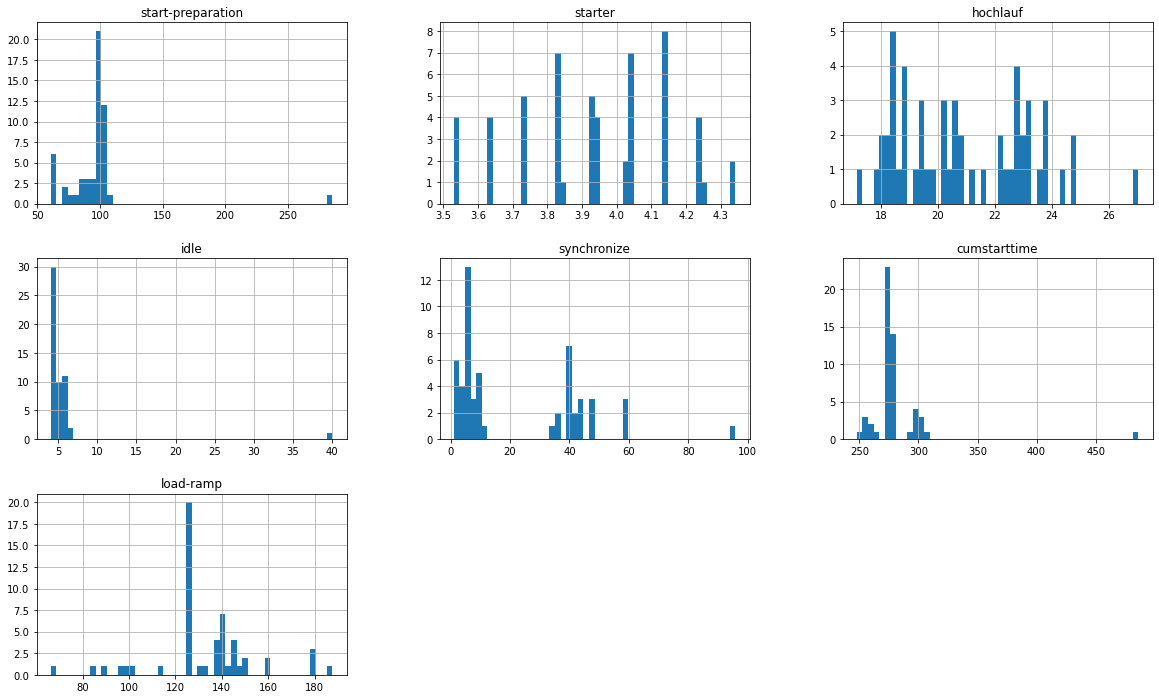

In [29]:
rda[['start-preparation','starter','hochlauf','idle','synchronize','cumstarttime','load-ramp','target-operation']].hist(figsize = (20,12), bins=50, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [30]:
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7));
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7), sym='');

In [31]:
nalarms = []
ct = 0
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            print(f"{c['mode']:15} {a['state']:20} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}")
print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")


***********************************
**   0 nicht erfolgreiche Starts **
***********************************



In [32]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

<Figure size 432x288 with 0 Axes>

In [33]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

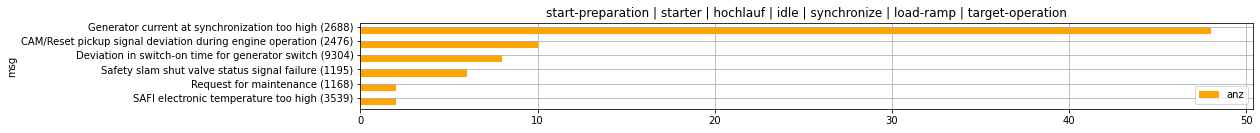

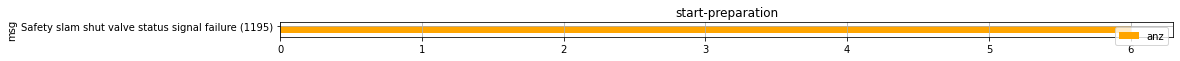

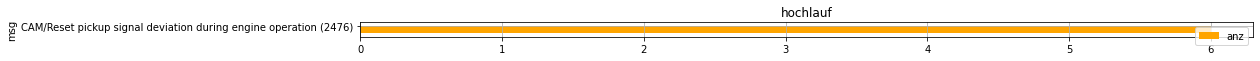

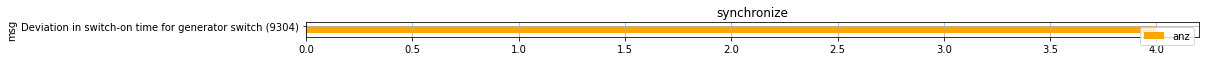

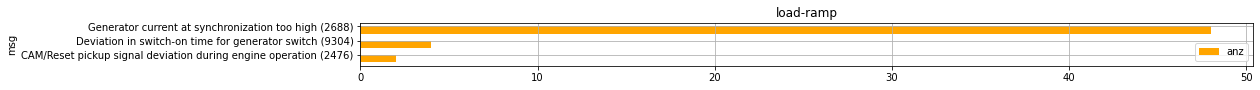

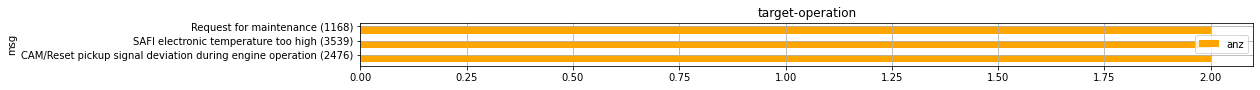

In [34]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [35]:
mfn = './data/' + str(e._sn) + '_messages.txt'
fsm.save_messages('./data/' + str(e._sn) + '_messages.txt')
print(mfn)

./data/1486144_messages.txt


In [36]:
any(fsm._messages['name'] == '9047')

True

In [37]:
#fsm.store()